In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler

In [60]:
# 1. 读取数据
file_path = r"D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step3_data.csv"
data = pd.read_csv(file_path)

In [61]:
# 2. 处理时间列
data['timestamp'] = pd.to_datetime(data['timestamp'])

# # 这里后续再统一做时间的特征工程
# data['hour'] = data['timestamp'].dt.hour
# data['dayofweek'] = data['timestamp'].dt.dayofweek
# data['month'] = data['timestamp'].dt.month
# data['year'] = data['timestamp'].dt.year
# data['day'] = data['timestamp'].dt.day

print(data.head())

            timestamp  Active_Power  Wind_Speed  Weather_Temperature_Celsius  \
0 2014-01-01 00:00:00           0.0    1.720666                    30.081875   
1 2014-01-01 00:05:00           0.0    1.263168                    29.945786   
2 2014-01-01 00:10:00           0.0    1.073596                    29.381653   
3 2014-01-01 00:15:00           0.0    1.203322                    28.800579   
4 2014-01-01 00:20:00           0.0    1.108955                    28.300385   

   Global_Horizontal_Radiation  Diffuse_Horizontal_Radiation  \
0                     1.267926                      0.587425   
1                     2.656051                      1.286431   
2                     4.119638                      2.647693   
3                     4.079689                      2.499754   
4                     4.032659                      2.465453   

   Radiation_Global_Tilted  Radiation_Diffuse_Tilted        T_c  
0                 0.928665                  1.656146  30.123320  
1 

In [62]:
# 3. 特征和目标列
X = data.drop(columns=['timestamp', 'Active_Power'])  # 除了目标列，其他列是特征
y = data['Active_Power']  # 目标列：功率

# 4. 数据标准化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# 保存 scaler，用于反归一化后续操作
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [63]:
# 5. 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False,random_state=42)

# 6. 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 7. 设置 LightGBM 参数
params = {
    'objective': 'regression',  # 回归任务
    'metric': 'mae',  # 使用 MAE 评估
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
# 8. 训练模型
num_round = 200
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=50)

D:\Acondae\tet\envs\tensorflow\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 153900, number of used features: 7
[LightGBM] [Info] Start training from score 0.250985
[1]	valid_0's l1: 0.307376
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 0.29294
[3]	valid_0's l1: 0.279265
[4]	valid_0's l1: 0.266269
[5]	valid_0's l1: 0.253942
[6]	valid_0's l1: 0.242226
[7]	valid_0's l1: 0.231059
[8]	valid_0's l1: 0.220464
[9]	valid_0's l1: 0.210438
[10]	valid_0's l1: 0.201274
[11]	valid_0's l1: 0.192234
[12]	valid_0's l1: 0.183667
[13]	valid_0's l1: 0.175541
[14]	valid_0's l1: 0.167843
[15]	valid_0's l1: 0.160538
[16]	valid_0's l1: 0.153628
[17]	valid_0's l1: 0.147034
[18]	valid_0's l1: 0.140751
[19]	valid_0's l1: 0.134838
[20]	valid_0's l1: 0.129274
[21]	valid_0's l1: 0.123993
[22]	valid_0's l

In [64]:
# 9. 预测
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 10. 评估模型
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

y_pred_scaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

MAE: 0.02954450608318989, MSE: 0.0033987918585314937, R2: 0.9727372394311901


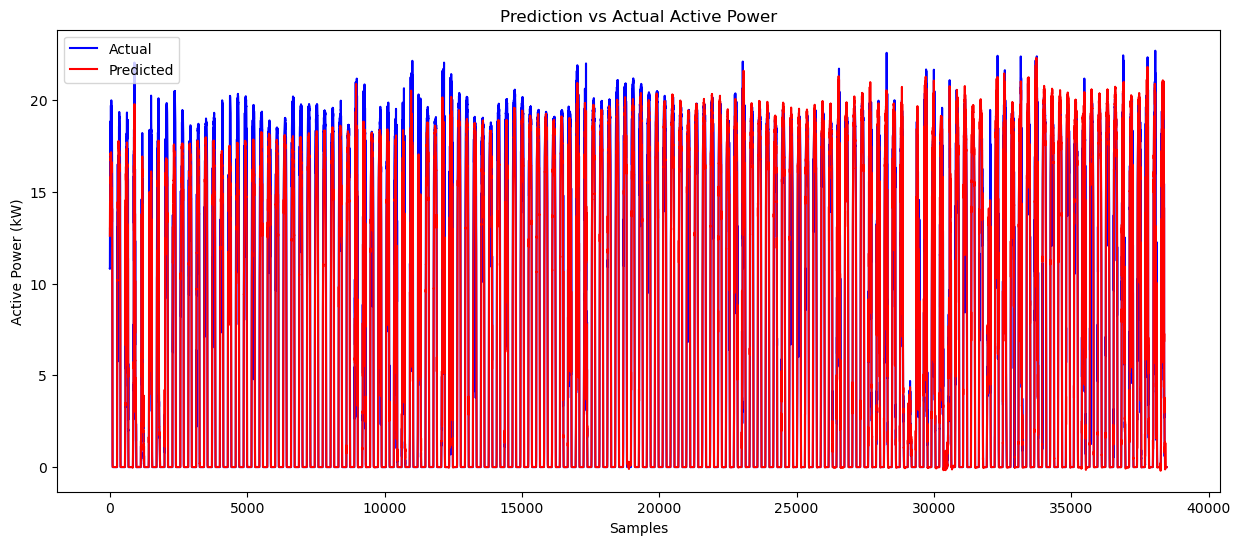

In [69]:
# 11. 绘图
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred_scaled, label='Predicted', color='red')
plt.title("Prediction vs Actual Active Power")
plt.xlabel("Samples")
plt.ylabel("Active Power (kW)")  # 假设功率单位是kW，按实际情况调整
plt.legend()
plt.show()


使用机器学习的R2更高一点，这里试着调一下网络的参数

In [74]:
from sklearn.model_selection import GridSearchCV
# 定义需要调节的参数网格
param_grid = {
    'num_leaves': range(20,60,5) ,  # 树的最大叶子数
    'max_depth': range(4,10,1),  # 树的最大深度，-1表示不限制
    'learning_rate': [0.01, 0.05, 0.1],  # 学习率
}
# 创建 LightGBM 回归器
lgb_reg = lgb.LGBMRegressor(objective='regression', metric='mae', boosting_type='gbdt',feature_fraction=0.9)
# 使用网格搜索进行调参
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# 训练模型
grid_search.fit(X_train, y_train)

# 打印最佳参数和最佳得分
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best MAE score found by GridSearchCV:", -grid_search.best_score_)

Best parameters found by GridSearchCV: {'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 30}
Best MAE score found by GridSearchCV: 0.030573187651590117


同时调多个参数速度很慢，因此分步来调，根据上面结果确定了学习率是0.1，max_depth是9，num_leaves是30

In [79]:
# 定义需要调节的参数网格
param_grid = {
    'n_estimators': range(10,300,50),  # 树的数量
    'subsample': [0.8, 0.9, 1.0],  # 每棵树使用的数据比例
    'colsample_bytree': [0.8, 0.9, 1.0]  # 每棵树使用的特征比例
}
# 创建 LightGBM 回归器
lgb_reg = lgb.LGBMRegressor(objective='regression', metric='mae', boosting_type='gbdt',feature_fraction=0.9,
                            num_leaves=30, max_depth=9, learning_rate=0.1)
# 使用网格搜索进行调参
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# 训练模型
grid_search.fit(X_train, y_train)

# 打印最佳参数和最佳得分
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best MAE score found by GridSearchCV:", -grid_search.best_score_)


Best parameters found by GridSearchCV: {'colsample_bytree': 0.8, 'n_estimators': 60, 'subsample': 0.8}
Best MAE score found by GridSearchCV: 0.03021465163788406


In [81]:
# 预测
y_pred_best = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')
y_pred_scaled_best = scaler_y.inverse_transform(y_pred_best.reshape(-1, 1)).flatten()

MAE: 0.03012702964711321, MSE: 0.003428560395975332, R2: 0.9727372394311901


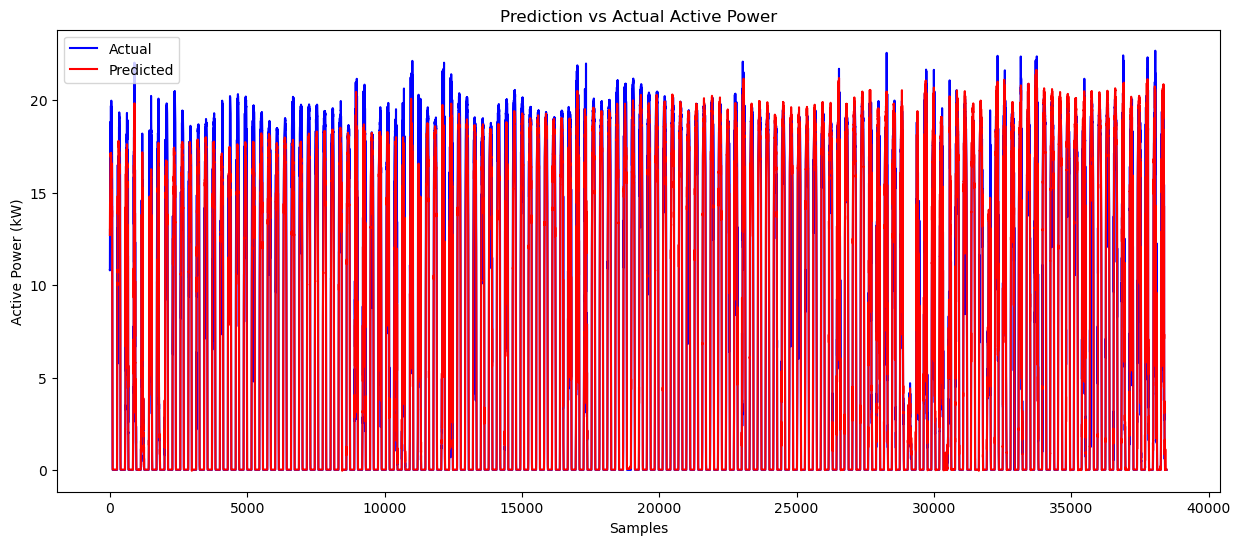

In [82]:
# 11. 绘图
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred_scaled_best, label='Predicted', color='red')
plt.title("Prediction vs Actual Active Power")
plt.xlabel("Samples")
plt.ylabel("Active Power (kW)")  # 假设功率单位是kW，按实际情况调整
plt.legend()
plt.show()

感觉调参最后的效果几乎没有提升，后续再深入研究调参技巧,先把模型参数保存一下

In [84]:
import joblib
joblib.dump(grid_search, 'lightgbm_model.pkl')

['lightgbm_model.pkl']